# Generative Adversarial Network

## Pre-processing data

In [46]:
import tensorflow as tf
import numpy as np
from IPython.display import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import os
import cv2
tf.reset_default_graph()

In [47]:
def crop_and_resize_64():
    if not os.path.isdir("img_align_celeba_64"):
        os.mkdir("img_align_celeba_64")
    for i in range(1, 202599 + 1):
        name = str(i).zfill(6) + ".jpg"
        img = cv2.imread("img_align_celeba/" + name, 1)
        img = cv2.resize(img[50:191,30:171], (64,64))
        cv2.imwrite("img_align_celeba_64/" + name, img)
#crop_and_resize_64()

In [48]:
## Here we will get the 100 000 first images and put them in a variable 178*218*3
dataset_size = 50000 #202599

        
def get_batch(batch_size):
        indexes = np.random.randint(1, dataset_size + 1, batch_size)
        data = []
        imgname = "img_align_celeba_64/"
        for i in indexes:
            #image = tf.read_file(imgname + str(i).zfill(6) + ".jpg")
            #image = tf.image.decode_jpeg(image, channels=3)
            image = mpimg.imread(imgname + str(i).zfill(6) + ".jpg")
            # Normalizing & centering images
            image = image - np.mean(image)
            image = image / np.var(image)
            data.append(image)
        return np.array(data)

def sample_Z(batch_size=50, n=128):
        return np.random.uniform(-1., 1., size=[batch_size, n])

In [49]:
def generator_cnn(Z, fc_sizes=[110,200,300], output_dim=3, reuse=False, alpha=0.2, keep_prob=0.5,is_train=True):
    
    with tf.variable_scope("GAN/Generator_cnn",reuse=reuse):      
         # 1. Fully connnected
        fc = tf.layers.dense(Z, 4*4*512, use_bias=False)
        fc = tf.reshape(fc, (-1, 4, 4, 512))
        bn0 = tf.layers.batch_normalization(fc, training=is_train)
        relu0 = tf.nn.relu(bn0)
        drop0 = tf.layers.dropout(relu0, keep_prob, training=is_train)
        
        # 2. Deconvolution 
        conv1 = tf.layers.conv2d_transpose(drop0, 256, 5, 2, 'same', use_bias=False)
        bn1 = tf.layers.batch_normalization(conv1, training=is_train)
        relu1 = tf.nn.relu(bn1)
        drop1 = tf.layers.dropout(relu1, keep_prob, training=is_train)
        
        # 3. Deconvolution
        conv2 = tf.layers.conv2d_transpose(drop1, 128, 5, 2, 'same', use_bias=False)
        bn2 = tf.layers.batch_normalization(conv2, training=is_train)
        relu2 = tf.nn.relu(bn2)
        drop2 = tf.layers.dropout(relu2, keep_prob, training=is_train)
        
        # 4. Deconvolution
        conv3 = tf.layers.conv2d_transpose(drop2, 64, 5, 2, 'same', use_bias=False)
        bn3 = tf.layers.batch_normalization(conv3, training=is_train)
        relu3 = tf.nn.relu(bn3)
        drop3 = tf.layers.dropout(relu3, keep_prob, training=is_train)
        
        # 5. dense, Output layer
        out = tf.layers.conv2d_transpose(drop3, output_dim, 5, 2, 'same')
        logits = tf.tanh(out)
        return logits


In [50]:
def discriminator_cnn(X, fc_sizes=[110,300,200], reuse=False, alpha=0.2, keep_prob=0.5):
    
    with tf.variable_scope("GAN/Discriminator_cnn",reuse=reuse):
        # Input layer is 64x64x3
        # Convolutional layer, 30x30x64
        conv1 = tf.layers.conv2d(X, 64, 5, 2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        lrelu1 = tf.maximum(alpha * conv1, conv1)
        drop1 = tf.layers.dropout(lrelu1, keep_prob)
        
        # Strided convolutional layer, 13x13x128
        conv2 = tf.layers.conv2d(drop1, 128, 5, 2, 'same', use_bias=False)
        bn2 = tf.layers.batch_normalization(conv2)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.layers.dropout(lrelu2, keep_prob)
        
        # Strided convolutional layer, 5x5x256
        conv3 = tf.layers.conv2d(drop2, 256, 5, 2, 'same', use_bias=False)
        bn3 = tf.layers.batch_normalization(conv3)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.layers.dropout(lrelu3, keep_prob)
        
        # Strided convolutional layer, 1x1x512
        conv4 = tf.layers.conv2d(drop3, 512, 5, 2, 'same', use_bias=False)
        bn4 = tf.layers.batch_normalization(conv4)
        lrelu4 = tf.maximum(alpha * bn4, bn4)
        drop4 = tf.layers.dropout(lrelu4, keep_prob)
        
        # fully connected
        flat = tf.reshape(drop4, (-1, 512))
        out0 = tf.layers.dense(flat, 1)
        out = tf.nn.sigmoid(out0)
        return out

In [51]:
X = tf.placeholder(tf.float32,[None,64,64,3])
#XX = tf.reshape(X, shape=(tf.shape(X)[0], 64*64*3))
Z = tf.placeholder(tf.float32,[None,128])

In [52]:
X_fake = generator_cnn(Z)

In [53]:
true_data_logits = discriminator_cnn(X)
fake_data_logits = discriminator_cnn(X_fake, reuse=True)

In [54]:
#D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=true_data_logits,labels=tf.ones_like(true_data_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_data_logits,labels=tf.zeros_like(fake_data_logits)))
#G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_data_logits,labels=tf.ones_like(fake_data_logits)))

D_loss = -tf.reduce_mean(true_data_logits) + tf.reduce_mean(fake_data_logits)
G_loss = -tf.reduce_mean(fake_data_logits)

batch_size = 64
lambda_gp = 10.0
# Gradient Penalty
epsilon = tf.random_uniform(shape=[batch_size,1, 1, 1], minval=0.,maxval=1.)
X_hat =  X + epsilon * (X_fake - X) #epsilon * X + (1-epsilon) * X_fake
D_X_hat = discriminator_cnn(X_hat, reuse=True)
grad_D_X_hat = tf.gradients(D_X_hat, [X_hat])[0]
reduction_indexes = [1]
slopes = tf.sqrt(tf.reduce_sum(tf.square(grad_D_X_hat), reduction_indices=reduction_indexes))
gradient_penalty = tf.reduce_mean((slopes - 1.) ** 2)
D_loss += lambda_gp * gradient_penalty

In [55]:
G_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator_cnn")
D_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator_cnn")

G_step = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.5, beta2=0.9).minimize(G_loss,var_list = G_variables)
D_step = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.5, beta2=0.9).minimize(D_loss,var_list = D_variables)

Iterations: 0	 Discriminator loss: 9.9158	 Generator loss: -0.0111
Iterations: 1	 Discriminator loss: 9.2233	 Generator loss: -0.8425
Iterations: 2	 Discriminator loss: 10.1277	 Generator loss: -0.0785
Iterations: 3	 Discriminator loss: 9.0887	 Generator loss: -0.7524
Iterations: 4	 Discriminator loss: 10.0869	 Generator loss: -0.5682
Iterations: 5	 Discriminator loss: 9.7963	 Generator loss: -0.0035
Iterations: 6	 Discriminator loss: 9.0163	 Generator loss: -0.4121
Iterations: 7	 Discriminator loss: 9.6834	 Generator loss: -0.2423
Iterations: 8	 Discriminator loss: 9.3515	 Generator loss: -0.0568
Iterations: 9	 Discriminator loss: 8.7046	 Generator loss: -0.9972
Iterations: 10	 Discriminator loss: 9.9324	 Generator loss: -0.5882
Iterations: 11	 Discriminator loss: 8.8170	 Generator loss: -0.0091
Iterations: 12	 Discriminator loss: 8.8326	 Generator loss: -0.0830
Iterations: 13	 Discriminator loss: 9.0735	 Generator loss: -0.2550
Iterations: 14	 Discriminator loss: 9.2599	 Generator lo

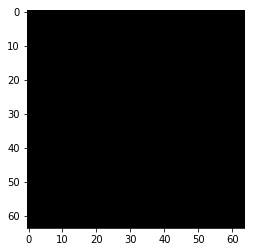

In [59]:
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)


nd_steps = 10
ng_steps = 10
#dataset = get_data_normalized(1000)

for i in range(25):
    X_batch = get_batch(batch_size)
    Z_batch = sample_Z(batch_size, 128)
    _, dloss = sess.run([D_step, D_loss], feed_dict={X: X_batch, Z: Z_batch})
    _, gloss = sess.run([G_step, G_loss], feed_dict={Z: Z_batch})

    print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))

Z_batch = sample_Z(1, 128)
X_batch = get_batch(1)
sess.run(X_fake, feed_dict={X: X_batch, Z: Z_batch})
plt.imshow(tf.reshape((255*(X_fake+1)/2), shape=(64, 64,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch}))

In [46]:
Z_batch = sample_Z(1, 128)
X_batch = get_batch(1)
sess.run(X_fake, feed_dict={X: X_batch, Z: Z_batch})
plt.imshow(tf.reshape(X_fake, shape=(64, 64,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch}))

Tensor("GAN/Generator_cnn/conv2d_transpose_3/BiasAdd:0", shape=(?, 64, 64, 3), dtype=float32)


TypeError: Fetch argument None has invalid type <class 'NoneType'>

In [16]:
Z_batch = sample_Z(1, 128)
X_batch = get_batch(1)
sess.run(G_sample, feed_dict={X: X_batch, Z: Z_batch})
plt.imshow(tf.reshape(G_sample, shape=(64, 64,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch}))

NameError: name 'G_sample' is not defined

In [17]:
Z_batch = sample_Z(1, 128)
X_batch = get_batch(1)
sess.run(G_sample, feed_dict={X: X_batch, Z: Z_batch})
plt.imshow(tf.reshape(G_sample, shape=(64, 64,3)).eval(session=sess, feed_dict={X: X_batch, Z: Z_batch}))

NameError: name 'G_sample' is not defined